<a href="https://colab.research.google.com/github/pravalika-n25/BDA/blob/main/BDA_160122771011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***BDA ASSIGNMENT-2 ~ 160122771011***

# **Initializing spark session and Loading Wine quality dataset into colab.**

In [22]:
#initializing spark session
from pyspark.sql import SparkSession

try:
    spark = SparkSession.builder \
        .appName("ClassificationModel") \
        .getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")
    print("Spark session initialized successfully.")
except Exception as e:
    print(f"Error initializing Spark session: {e}")
    exit(1)

Spark session initialized successfully.


In [23]:
from google.colab import files
uploaded = files.upload()

file_path = '/content/WineQT.csv'

#reading the dataset using Spark
df = spark.read.csv(file_path, header=True, inferSchema=True)

#Show the first few rows of the dataset
df.show(5)

Saving WineQT.csv to WineQT (3).csv
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+---+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality| Id|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+---+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|  0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|  1|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|  2|
|         11.2|            0.28|       0

#**1) Build a Classification Model with Spark with a dataset of your choice.**

In [24]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Prepare features and label columns (excluding 'quality' and 'Id')
feature_columns = [col for col in df.columns if col not in ['quality', 'Id']]

#Initialize VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

#Initialize Logistic Regression model
lr = LogisticRegression(labelCol='quality', featuresCol='features')

#Creating a pipeline with assembler and logistic regression stages
pipeline = Pipeline(stages=[assembler, lr])

#Splitting data into training and testing sets (80% training, 20% testing)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

#Fit the pipeline model using the training data
model = pipeline.fit(train_data)

#Making predictions on the test data
predictions = model.transform(test_data)

#Evaluate the model's performance using accuracy
evaluator = BinaryClassificationEvaluator(labelCol='quality', rawPredictionCol='prediction')
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


#**2) Build a Clustering Model with Spark with a dataset of your choice.**

Silhouette Score: 0.77


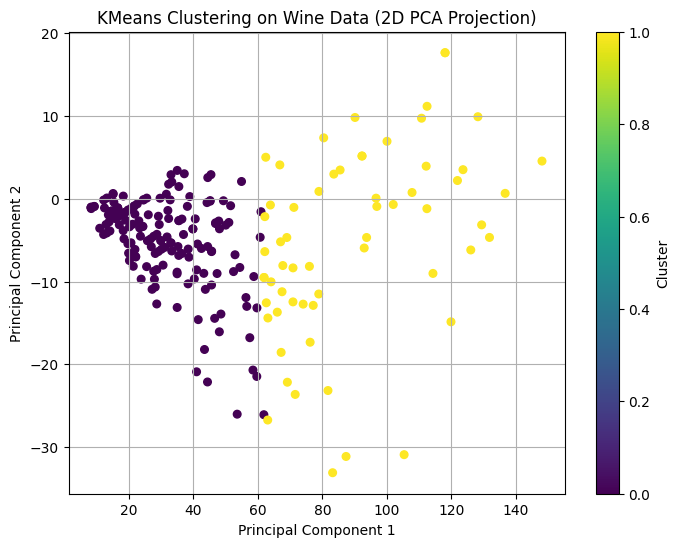

In [25]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

#Initialize Spark session
spark = SparkSession.builder \
    .appName("WineKMeansClustering") \
    .getOrCreate()

#Load the data
df = spark.read.csv('/content/WineQT (1).csv', header=True, inferSchema=True)

#Prepare features and label columns (excluding 'quality' and 'Id')
feature_columns = [col for col in df.columns if col not in ['quality', 'Id']]

#Initialize VectorAssembler to create 'features' column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

#Initialize KMeans model (k=3, you can change k depending on the dataset)
kmeans = KMeans(k=3, seed=1234, featuresCol='features', predictionCol='prediction')

#Creating a pipeline with assembler and KMeans model
pipeline = Pipeline(stages=[assembler, kmeans])

#Splitting data into training and testing sets (80% training, 20% testing)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

#Fit the pipeline model using the training data
model = pipeline.fit(train_data)

#Making predictions on the test data
predictions = model.transform(test_data)

#Evaluate the clustering performance using ClusteringEvaluator
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features')
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette_score:.2f}")

#Apply PCA to reduce to 2D for plotting
pca = PCA(k=2, inputCol='features', outputCol='pcaFeatures')
pca_model = pca.fit(predictions)
pca_result = pca_model.transform(predictions)

#Collecting data to Pandas for plotting
pandas_df = pca_result.select('pcaFeatures', 'prediction').toPandas()

#Extracting X, Y, and cluster labels
x = pandas_df['pcaFeatures'].apply(lambda x: x[0])
y = pandas_df['pcaFeatures'].apply(lambda x: x[1])
labels = pandas_df['prediction']

#Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=labels, cmap='viridis', s=30)
plt.title("KMeans Clustering on Wine Data (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

#**3) Build a Recommendation Engine with Spark with a dataset of your choice.**

+------+------------------+-------+
|itemId|           distCol|quality|
+------+------------------+-------+
|   752|1.5438594827574175|      5|
|  1173|2.5254823558282884|      6|
|  1174|2.5254823558282884|      6|
|  1357|2.5255890604767823|      6|
|   796| 3.338695019854314|      5|
+------+------------------+-------+



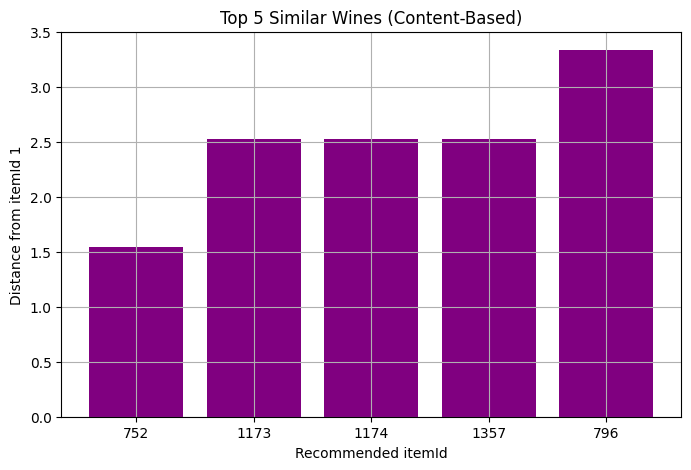

In [26]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, BucketedRandomProjectionLSH
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

#Starting Spark session
spark = SparkSession.builder.appName("WineContentBasedRec").getOrCreate()

#Loading data
df = spark.read.csv('/content/WineQT (1).csv', header=True, inferSchema=True)

#Assemble features
feature_cols = [
    'fixed acidity','volatile acidity','citric acid','residual sugar',
    'chlorides','free sulfur dioxide','total sulfur dioxide',
    'density','pH','sulphates','alcohol'
]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
dataset = assembler.transform(df).select(col('Id').alias('itemId'), 'features', 'quality')

#Fit LSH model
lsh = BucketedRandomProjectionLSH(
    inputCol='features',
    outputCol='hashes',
    bucketLength=1.0,
    numHashTables=5
)
lsh_model = lsh.fit(dataset)

#Query vector for itemId = 1
query_vec = dataset.filter(col('itemId') == 1).select('features').head()[0]

#Get 6 nearest neighbors
neighbors = lsh_model.approxNearestNeighbors(dataset, query_vec, 6)

#Filter out self and display top 5
results = neighbors.filter(col('itemId') != 1).orderBy('distCol')
results.select('itemId', 'distCol', 'quality').show(5)

#Plotting
pdf = results.filter(col('itemId') != 1).orderBy('distCol').select('itemId', 'distCol').toPandas()
plt.figure(figsize=(8,5))
plt.bar(pdf['itemId'].astype(str), pdf['distCol'], color='purple')
plt.xlabel('Recommended itemId')
plt.ylabel('Distance from itemId 1')
plt.title('Top 5 Similar Wines (Content-Based)')
plt.grid(True)
plt.show()